# Clockwork Axion

In [71]:
%run observables.py
%run clockwork_axion.py

## Parameterspace from Paper

In [53]:
N = 10
m_phi_range = np.geomspace(1e-6, 1e6, N + 1) * 1e-9 # [GeV]
mR_range = np.linspace(1, 15, N)
sim_f_eff = f_eff = 1e13
H_inf = 1e8
Gamma_inf = H_inf

In [54]:
def fn(m_phi, mR, i, j, debug=False):
    eps = calc_eps(mR)
    f = calc_f(f_eff, eps)
    M = m_phi / eps
    ax0 = (theta_to_phi_over_f(1.0, eps), 0.0)
    n = i + j * len(m_phi_range) + 1
    print("step:", n, "of", len(m_phi_range) * len(mR_range), end="")
    start = time.time()
    try:
        x = compute_observables(H_inf, Gamma_inf, (eps, M), f, 
            clockwork_axion_field, axion_init=ax0, calc_init_time=True, debug=debug)
    except ValueError as e:
        print(e)
        x = np.nan
    end = time.time()
    print(" done (%f seconds)" % (end - start))
    return x

In [65]:
%time obs = np.array([[fn(m_phi, mR, i, j) for i, m_phi in enumerate(m_phi_range)] for j, mR in enumerate(mR_range)])

step: 1 of 110 done (13.945742 seconds)
step: 2 of 110 done (12.452429 seconds)
step: 3 of 110 done (12.551836 seconds)
step: 4 of 110 done (5.587183 seconds)
step: 5 of 110 done (5.351674 seconds)
step: 6 of 110 done (5.126792 seconds)
step: 7 of 110 done (4.886208 seconds)
step: 8 of 110 done (4.977621 seconds)
step: 9 of 110 done (4.736439 seconds)
step: 10 of 110 done (4.813022 seconds)
step: 11 of 110

/home/jana/Documents/masters-project/transport_eq_in_time/transport_equation.py:150: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


 done (4.548427 seconds)
step: 12 of 110 done (4.726842 seconds)
step: 13 of 110 done (4.298655 seconds)
step: 14 of 110 done (4.398865 seconds)
step: 15 of 110 done (4.420212 seconds)
step: 16 of 110 done (4.113303 seconds)
step: 17 of 110 done (4.057677 seconds)
step: 18 of 110 done (4.130665 seconds)
step: 19 of 110 done (3.868051 seconds)
step: 20 of 110 done (4.280116 seconds)
step: 21 of 110 done (3.436242 seconds)
step: 22 of 110 done (3.666176 seconds)
step: 23 of 110 done (4.866626 seconds)
step: 24 of 110 done (4.845378 seconds)
step: 25 of 110 done (4.507001 seconds)
step: 26 of 110 done (4.567920 seconds)
step: 27 of 110 done (4.421522 seconds)
step: 28 of 110 done (4.366866 seconds)
step: 29 of 110 done (4.382800 seconds)
step: 30 of 110 done (4.096681 seconds)
step: 31 of 110 done (3.897996 seconds)
step: 32 of 110 done (3.459113 seconds)
step: 33 of 110 done (3.269855 seconds)
step: 34 of 110 done (4.687803 seconds)
step: 35 of 110 done (4.359973 seconds)
step: 36 of 110

Text(0, 0.5, 'mR')

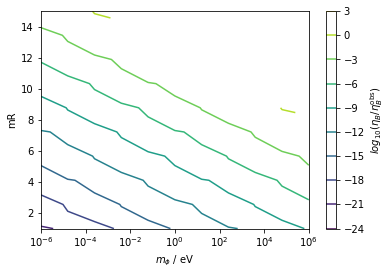

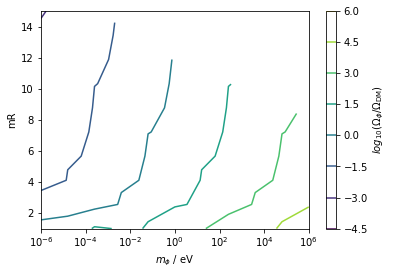

In [70]:
eta = obs[:, :, 0] * obs[:, :, 1]
Omega_h_sq = obs[:, :, 2] 
plt.figure()
plt.contour(m_phi_range * 1e9, mR_range, np.log10(eta / eta_observed))
plt.xscale("log")
plt.colorbar(label=r"$log_{10}(\eta_B / \eta_B^\mathrm{obs})$")
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")
plt.figure()
plt.contour(m_phi_range * 1e9, mR_range, np.log10(Omega_h_sq / Omega_DM_h_sq))
plt.xscale("log")
plt.colorbar(label=r"$log_{10}(\Omega_\phi / \Omega_\mathrm{DM})$")
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

Text(0, 0.5, 'mR')

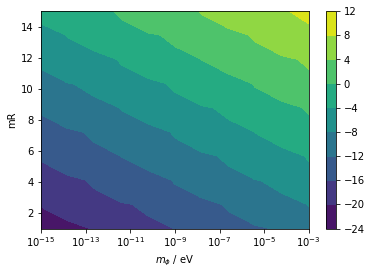

In [16]:
curvature = np.array([[calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
            for m_phi in m_phi_range] for mR in mR_range])
plt.contourf(m_phi_range * 1e9, mR_range, np.log10(np.sqrt(curvature) / H_inf) )
plt.xscale("log")
plt.colorbar()
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

Text(0.5, 0, 'mR')

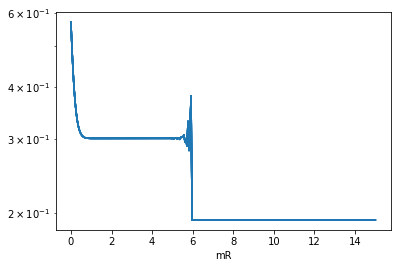

In [29]:
for m_phi in m_phi_range:
    mRs = np.linspace(0, 15, 300)
    A = np.array([calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
                   / (m_phi / calc_eps(mR))**2 for mR in mRs])
    plt.plot(mRs, A, color="tab:blue")
plt.yscale("log")
plt.xlabel(r"mR")

## Plot of the effective Potential

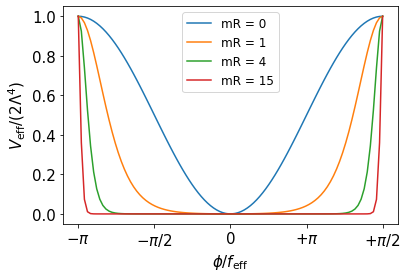

In [5]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
M = m_phi / eps 
alpha_range = np.linspace(-np.pi, np.pi, 100)
for plot_mR in [0, 1, 4, 15]:
    eps = calc_eps(plot_mR)
    phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    plt.plot(alpha_range, y, label=f"mR = {plot_mR}")
plt.xlabel(r"$\phi / f_\mathrm{eff}$", fontsize=15)
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$", fontsize=15)
plt.legend(fontsize=12)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi/2$", r"$+\pi$",], fontsize=15)
plt.yticks(fontsize=15);

## Example Evolution

step = 1
calculcated initial integration time:
tmax_inf_time = 36.93551012003315 tmax_axion_time = 5.671555999259314e-06
rh: 0.15078306198120117
axion: 0.09100484848022461
transport eq.: 0.16532158851623535
change by timescale: 257453.05922942486 vs 0.001
B-L range: -2.4826319728898255e-20 0.0
delta = 5.899732255337614 rtol_asym = 0.001
step = 2
rh: 0.04710674285888672
axion: 0.1828148365020752
transport eq.: 0.6658234596252441
change by timescale: 0.008248875257700483 vs 0.001
B-L range: -1.0807734675439224e-13 -2.482631972889816e-20
delta = 9.627036100275065 rtol_asym = 0.001
step = 3
rh: 0.00020074844360351562
axion: 0.026491641998291016


/home/jana/Documents/masters-project/transport_eq_in_time/transport_equation.py:150: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


transport eq.: 0.4246408939361572
change by timescale: 0.0005332328346081921 vs 0.001
B-L range: -1.1063583214331653e-13 -1.0807734675439224e-13
delta = 0.02361744217752807 rtol_asym = 0.001
step = 4
rh: 0.00035691261291503906
axion: 0.02407073974609375
transport eq.: 0.3012993335723877
change by timescale: 0.00011380334047081065 vs 0.001
B-L range: -1.1094719998831935e-13 -1.1063583214331976e-13
delta = 0.0028137038238903447 rtol_asym = 0.001
step = 5
rh: 0.000186920166015625
axion: 0.016496658325195312
transport eq.: 0.33139657974243164
change by timescale: 3.958996053343153e-05 vs 0.001
B-L range: -1.1103420410096375e-13 -1.1094719998832258e-13
delta = 0.000784148136109563 rtol_asym = 0.001
<__main__.ClockworkAxionField object at 0x7fc322fcaaf0> (6.512412136079906e-09, 15.35529353954466)
advancing to oscillation
t_advance = 230329399.8196812
H = 0.15274224252537802, H_osc = 2.1708040453599684e-09
step = 1: delta = nan vs 0.001
step = 2: delta = 0.0007090073517869064 vs 0.001
relic d

(9.676519478913712e-16, 1.0, 10.483713585280677, 1.0)

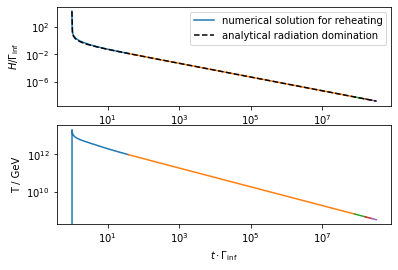

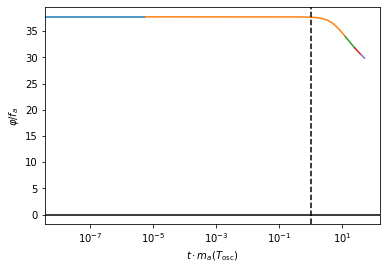

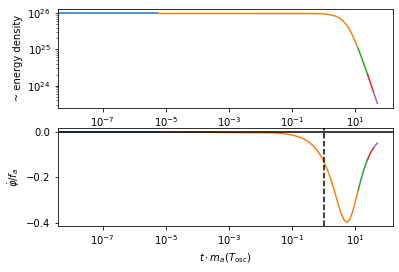

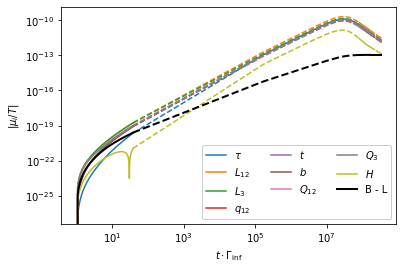

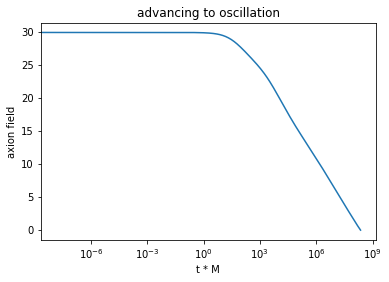

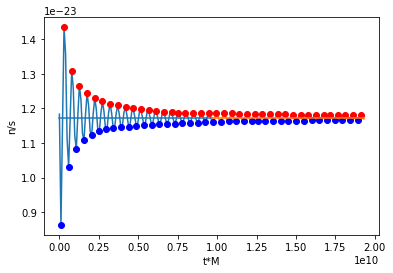

In [10]:
%run observables.py
%run clockwork_axion.py
H_inf = 2e12
Gamma_inf = 1e8
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
M = m_phi / eps 
compute_observables(H_inf, Gamma_inf, (eps, M), f, clockwork_axion_field, (theta_to_phi_over_f(1.0, eps), 0.0), 
                    calc_init_time=True, debug=True)